# Unsupervised Learning Residency-5 Project-2 - Vehicle Case Study

Case Study Description: Vehicle Classification

The purpose of the case study is to classify a given silhouette as one of four different types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles. Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars. The purpose is to classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.

The points distribution for this case is as follows:

Data pre-processing - Understand the data and treat missing values (Use box plot), outliers (5 points)

Understanding the attributes - Find relationship between different attributes (Independent variables) and choose carefully which all attributes have to be a part of the analysis and why (5 points)

Use PCA from scikit learn and elbow plot to find out reduced number of dimension (which covers more than 95% of the variance) - 10 points

Use Support vector machines and use grid search (try C values - 0.01, 0.05, 0.5, 1 and kernel = linear, rbf) and find out the best hyper parameters and do cross validation to find the accuracy. (10 points)

In [104]:
# import all necessary packages
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import zscore
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC 

#from sklearn.model_selection import GridSearchC
from sklearn.model_selection import GridSearchCV

# 1. Data pre-processing - Understand the data and treat missing values (Use box plot), outliers (5 points)

In [6]:
# Read the dataset
df = pd.read_csv("vehicle_Project_USL.csv")
df.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio class  
0             187.0            197   van  
1             189.0            199   van  
2             188.0            196   car  
3             199.0            207   van  
4             180.0            183   bus

In [7]:
df.shape

(846, 19)

In [8]:
df.info() #here many values are not 846, whch means we are having null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           842 non-null float64
radius_ratio                   840 non-null float64
pr.axis_aspect_ratio           844 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  845 non-null float64
elongatedness                  845 non-null float64
pr.axis_rectangularity         843 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                843 non-null float64
scaled_variance.1              844 non-null float64
scaled_radius_of_gyration      844 non-null float64
scaled_radius_of_gyration.1    842 non-null float64
skewness_about                 840 non-null float64
skewness_about.1               845 non-null float64
skewness_about.2               845 non-null float64
hollows_ratio    

We could find the missing values on most of the features and the class column is showing has the categoriacal variable. First we will convert the categoraical varible in to numeric

# Convert Categorical to number

In [9]:
df["class"].unique()

array(['van', 'car', 'bus'], dtype=object)

In [10]:
df["class"].value_counts()

car    429
bus    218
van    199
Name: class, dtype: int64

In [11]:
labelencoder = LabelEncoder()
df["class"] = labelencoder.fit_transform(df["class"]) #label Encoding the class column and fit into the same column

In [12]:
df["class"].head()

0    2
1    2
2    1
3    2
4    0
Name: class, dtype: int32

In [13]:
df[["class"]].head()

class
0      2
1      2
2      1
3      2
4      0

We will remove the class feature while defining the target variable

In [14]:
df.describe().T

count        mean         std    min     25%  \
compactness                  846.0   93.678487    8.234474   73.0   87.00   
circularity                  841.0   44.828775    6.152172   33.0   40.00   
distance_circularity         842.0   82.110451   15.778292   40.0   70.00   
radius_ratio                 840.0  168.888095   33.520198  104.0  141.00   
pr.axis_aspect_ratio         844.0   61.678910    7.891463   47.0   57.00   
max.length_aspect_ratio      846.0    8.567376    4.601217    2.0    7.00   
scatter_ratio                845.0  168.901775   33.214848  112.0  147.00   
elongatedness                845.0   40.933728    7.816186   26.0   33.00   
pr.axis_rectangularity       843.0   20.582444    2.592933   17.0   19.00   
max.length_rectangularity    846.0  147.998818   14.515652  118.0  137.00   
scaled_variance              843.0  188.631079   31.411004  130.0  167.00   
scaled_variance.1            844.0  439.494076  176.666903  184.0  318.00   
scaled_radius_of_gyration    844.0  174.709716   32.584808  109.0  149.00   
scaled_radius_of_gyration.1  842.0   72.447743    7.486190   59.0   67.00   
skewness_about               840.0    6.364286    4.920649    0.0    2.00   
skewness_about.1             845.0   12.602367    8.936081    0.0    5.00   
skewness_about.2             845.0  188.919527    6.155809  176.0  184.00   
hollows_ratio                846.0  195.632388    7.438797  181.0  190.25   
class                        846.0    0.977541    0.702130    0.0    0.00   

                               50%    75%     max  
compactness                   93.0  100.0   119.0  
circularity                   44.0   49.0    59.0  
distance_circularity          80.0   98.0   112.0  
radius_ratio                 167.0  195.0   333.0  
pr.axis_aspect_ratio          61.0   65.0   138.0  
max.length_aspect_ratio        8.0   10.0    55.0  
scatter_ratio                157.0  198.0   265.0  
elongatedness                 43.0   46.0    61.0  
pr.axis_rectangularity        20.0   23.0    29.0  
max.length_rectangularity    146.0  159.0   188.0  
scaled_variance              179.0  217.0   320.0  
scaled_variance.1            363.5  587.0  1018.0  
scaled_radius_of_gyration    173.5  198.0   268.0  
scaled_radius_of_gyration.1   71.5   75.0   135.0  
skewness_about                 6.0    9.0    22.0  
skewness_about.1              11.0   19.0    41.0  
skewness_about.2             188.0  193.0   206.0  
hollows_ratio                197.0  201.0   211.0  
class                          1.0    1.0     2.0

# Missing Value Treatment

In [15]:
df.isnull().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

In [16]:
df.isna().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

In [17]:
df= df.groupby(df.columns, axis = 1).transform(lambda x: x.fillna(x.mean())) 
#Grouping all the columns, Initiating a lambda function x, x.fillna (if nullcomes) replace with x.mean values 

In [18]:
df.isna().sum() # All the values are now replaced, except circularity col

compactness                    0
circularity                    5
distance_circularity           0
radius_ratio                   0
pr.axis_aspect_ratio           0
max.length_aspect_ratio        0
scatter_ratio                  0
elongatedness                  0
pr.axis_rectangularity         0
max.length_rectangularity      0
scaled_variance                0
scaled_variance.1              0
scaled_radius_of_gyration      0
scaled_radius_of_gyration.1    0
skewness_about                 0
skewness_about.1               0
skewness_about.2               0
hollows_ratio                  0
class                          0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           846 non-null float64
radius_ratio                   846 non-null float64
pr.axis_aspect_ratio           846 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  846 non-null float64
elongatedness                  846 non-null float64
pr.axis_rectangularity         846 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                846 non-null float64
scaled_variance.1              846 non-null float64
scaled_radius_of_gyration      846 non-null float64
scaled_radius_of_gyration.1    846 non-null float64
skewness_about                 846 non-null float64
skewness_about.1               846 non-null float64
skewness_about.2               846 non-null float64
hollows_ratio    

In [20]:
df[["circularity"]].head(10) #We can see some NaN values in the column

circularity
0         48.0
1         41.0
2         50.0
3         41.0
4         44.0
5          NaN
6         43.0
7         43.0
8         34.0
9         44.0

In [23]:
df['circularity'] = df['circularity'].fillna((df['circularity'].mean())) #Replacing the NaN values in the circularity column

In [25]:
df.isnull().sum()  #The Values are replaced

compactness                    0
circularity                    0
distance_circularity           0
radius_ratio                   0
pr.axis_aspect_ratio           0
max.length_aspect_ratio        0
scatter_ratio                  0
elongatedness                  0
pr.axis_rectangularity         0
max.length_rectangularity      0
scaled_variance                0
scaled_variance.1              0
scaled_radius_of_gyration      0
scaled_radius_of_gyration.1    0
skewness_about                 0
skewness_about.1               0
skewness_about.2               0
hollows_ratio                  0
class                          0
dtype: int64

In [32]:
df_vehicles.dtypes

compactness                      int64
circularity                    float64
distance_circularity           float64
radius_ratio                   float64
pr.axis_aspect_ratio           float64
max.length_aspect_ratio          int64
scatter_ratio                  float64
elongatedness                  float64
pr.axis_rectangularity         float64
max.length_rectangularity        int64
scaled_variance                float64
scaled_variance.1              float64
scaled_radius_of_gyration      float64
scaled_radius_of_gyration.1    float64
skewness_about                 float64
skewness_about.1               float64
skewness_about.2               float64
hollows_ratio                    int64
class                           object
dtype: object

In [41]:
df_vehicles[['circularity']].head()

circularity
0         48.0
1         41.0
2         50.0
3         41.0
4         44.0

In [33]:
df_vehicles[['circularity']] = df_vehicles[['circularity']].apply(lambda x: x.fillna(x.mean()))
#Imputing the null values using lambda apply function

In [36]:
df_vehicles[['circularity']].head()

circularity
0         48.0
1         41.0
2         50.0
3         41.0
4         44.0

# Identifying the outlier using Box plot and Histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DA22F061D0>,
      dtype=object)

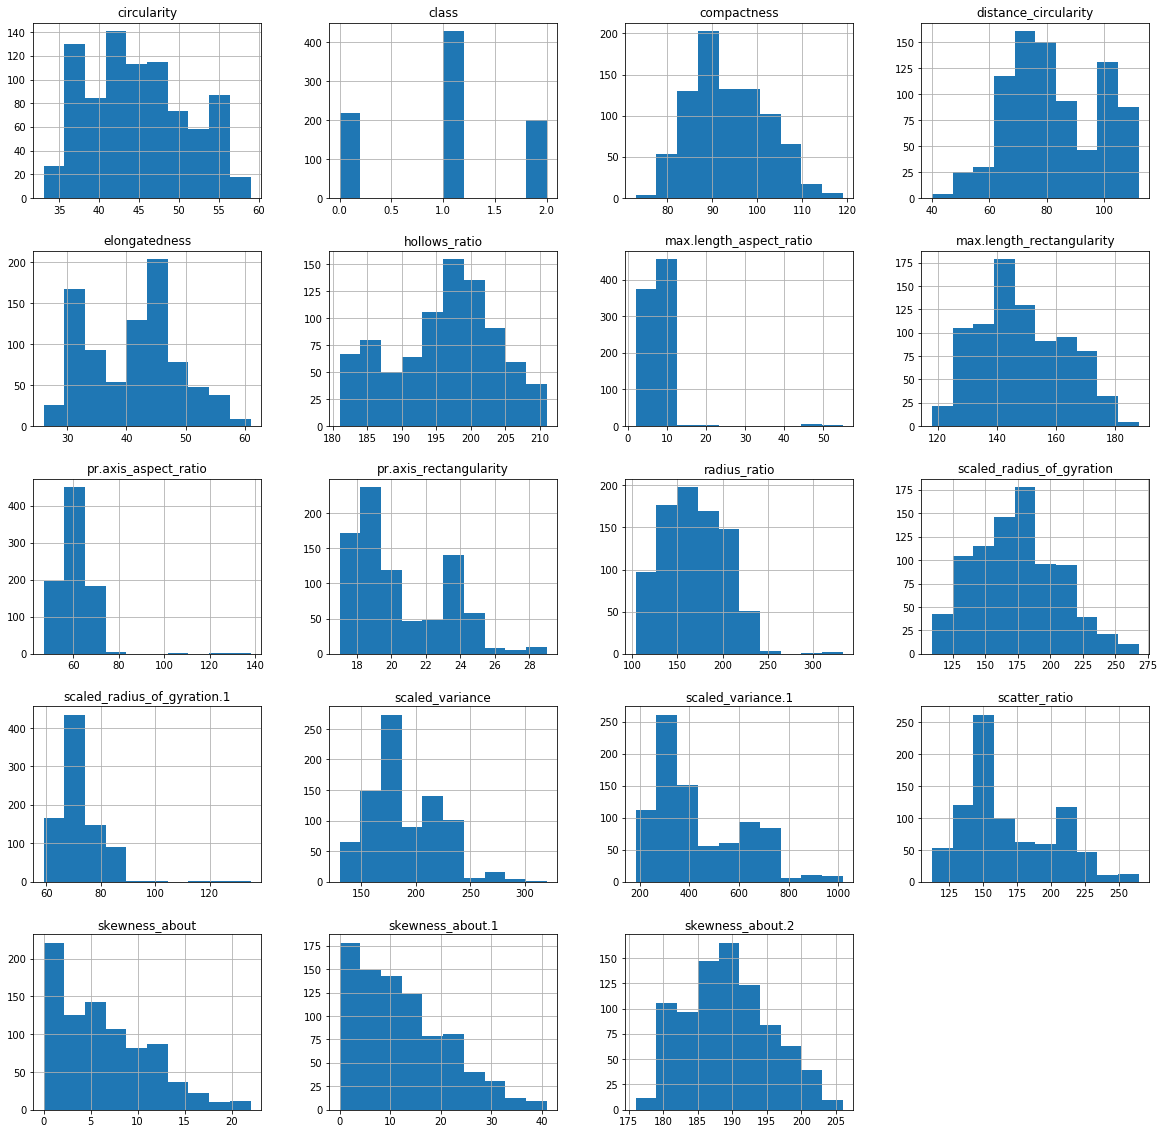

In [37]:
# perform univariant analysis by generating histogram of all dimensions
df.hist(figsize = [20,20])

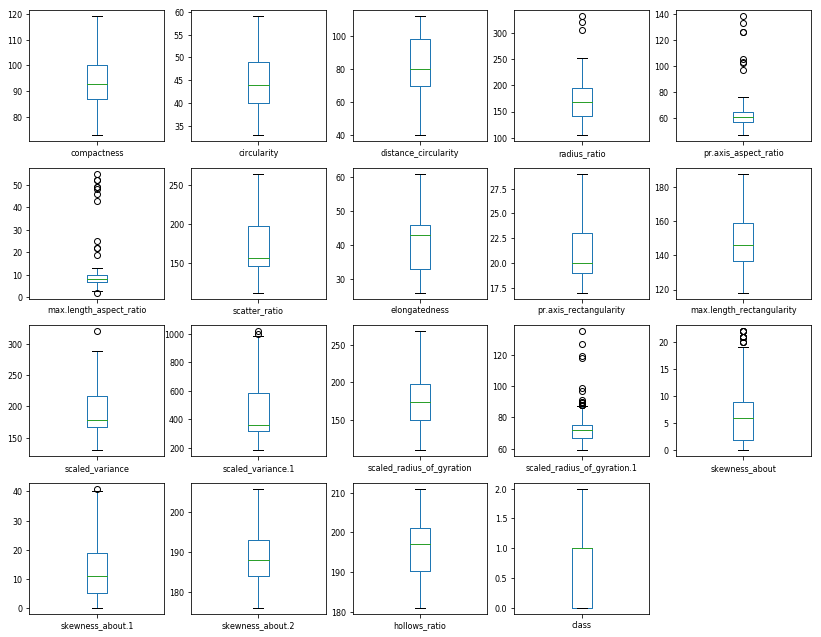

In [38]:
# box plots for independent feature(features with numerical values) to check the outliers
df.plot(kind='box', subplots=True, layout=(5,5), fontsize=8, figsize=(14,14))
plt.show()

Outliers are observed for radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scaled_variance, scaled_variance.1, scaled_radius_of_gyration.1, skewness_about, skewness_about.1

In [39]:
df.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio  class  
0             187.0            197      2  
1             189.0            199      2  
2             188.0            196      1  
3             199.0            207      2  
4             180.0            183      0

# Treating Outlier using Zscore

In [40]:
from scipy import stats
z = np.abs(stats.zscore(df))
print(z)

[[0.16058035 0.51730193 0.05654535 ... 0.31219283 0.18395733 1.45708611]
 [0.32546965 0.62456401 0.12011169 ... 0.01308823 0.45297703 1.45708611]
 [1.25419283 0.84354934 1.51857115 ... 0.1495523  0.04944748 0.03200536]
 ...
 [1.49721783 1.49604417 1.20073946 ... 0.31219283 0.72199673 0.03200536]
 [0.93303214 1.44018254 0.26128634 ... 0.17572877 0.08506238 0.03200536]
 [1.05454464 1.44018254 1.02408241 ... 0.47483337 0.75761164 1.45708611]]


Looking the code and the output above, it is difficult to say which data point is an outlier. Let’s try and define a threshold to identify an outlier.

In [47]:
threshold = 1
print(np.where(z > 1))

(array([  0,   0,   1, ..., 845, 845, 845], dtype=int64), array([ 4, 18, 18, ..., 12, 14, 18], dtype=int64))


In [48]:
threshold = 2
print(np.where(z > 2))

(array([  4,   4,   4,   5,   5,   5,   5,   5,  11,  15,  16,  33,  35,
        37,  37,  37,  37,  37,  41,  44,  44,  47,  52,  53,  54,  54,
        54,  54,  61,  65,  67,  71,  71,  73,  73,  79,  85,  85,  85,
        85,  85,  85,  96,  98, 100, 100, 100, 100, 103, 106, 112, 113,
       113, 113, 123, 125, 127, 131, 132, 135, 135, 135, 135, 142, 146,
       148, 152, 155, 155, 155, 155, 158, 161, 165, 166, 166, 167, 171,
       171, 171, 171, 171, 176, 183, 190, 193, 193, 193, 193, 193, 196,
       202, 219, 219, 220, 230, 230, 230, 231, 231, 248, 249, 251, 251,
       255, 255, 259, 259, 274, 274, 274, 274, 278, 283, 291, 291, 291,
       291, 294, 294, 294, 294, 294, 297, 298, 309, 317, 317, 321, 321,
       321, 321, 321, 321, 326, 326, 330, 334, 334, 338, 344, 345, 345,
       345, 345, 345, 346, 346, 347, 349, 350, 357, 361, 374, 375, 381,
       381, 381, 381, 381, 381, 388, 388, 388, 388, 388, 389, 391, 396,
       396, 396, 396, 396, 400, 411, 413, 425, 427, 428, 439, 4

In [42]:
threshold = 3
print(np.where(z > 3))

(array([  4,   4,   4,  37,  37,  37,  37,  44,  85, 100, 100, 100, 123,
       132, 135, 135, 135, 135, 291, 291, 321, 321, 388, 388, 388, 388,
       388, 391, 396, 513, 516, 523, 523, 623, 687, 687, 706, 706, 706,
       733, 761, 835, 835, 835], dtype=int64), array([ 4,  5, 13,  3,  4,  5, 13,  0, 11,  4,  5, 13, 14, 15,  3,  4,  5,
       13,  4,  5, 10, 11,  3,  4,  5, 10, 13,  5, 10, 15, 14,  4,  5, 14,
       10, 11,  4,  5, 13, 10, 14,  8, 10, 11], dtype=int64))


The first array contains the list of row numbers and second array respective column numbers, which mean z[4][4] have a Z-score higher than 3.

In [43]:
print(z[4][4])

5.245484832830666


So, the data point — 4th record on column Z4 is an outlier. Now we want to remove or filter the outliers and get the clean data. This can be done with just one line code as we have already calculated the Z-score.

In [44]:
df.shape

(846, 19)

In [49]:
df_z = df[(z < 3).all(axis=1)] #Considering the values which is less the z=3

In [51]:
df_z.shape

(824, 19)

We can see that 22 rows have been dropped due to outlier removal.

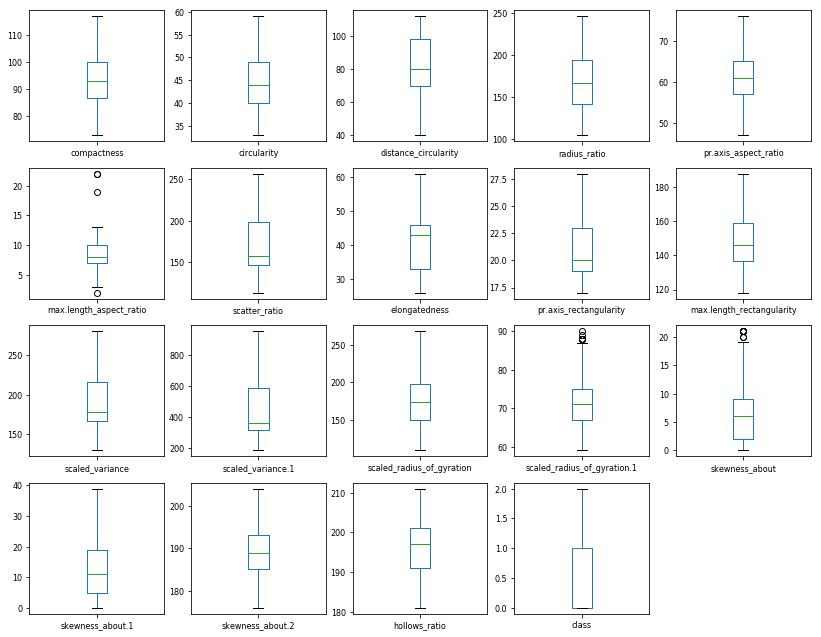

In [53]:
df_z.plot(kind='box', subplots=True, layout=(5,5), fontsize=8, figsize=(14,14))
plt.show()

Still we could see some outliers so we can try another method call inter quatile range to treat the outlier (Upper Outlier)

# Treating Outlier using IQR Score

In [54]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

compactness                     13.00
circularity                      9.00
distance_circularity            28.00
radius_ratio                    54.00
pr.axis_aspect_ratio             8.00
max.length_aspect_ratio          3.00
scatter_ratio                   51.00
elongatedness                   13.00
pr.axis_rectangularity           4.00
max.length_rectangularity       22.00
scaled_variance                 50.00
scaled_variance.1              268.50
scaled_radius_of_gyration       49.00
scaled_radius_of_gyration.1      8.00
skewness_about                   7.00
skewness_about.1                14.00
skewness_about.2                 9.00
hollows_ratio                   10.75
class                            1.00
dtype: float64


In [55]:
df_vehicles_out = df[((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df_vehicles_out.shape 
#This is without ~ symbols, which considers only the outlier, 
#brings all values which is lesser than Q1 and higher than Q3

(33, 19)

In [56]:
df_vehicles_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df_vehicles_out.shape
#This is without ~ symbols, which omits only the outlier, 
#brings all values which is higher than Q1 and lesser than Q3 (1.5* IQR is a default calculation)

(813, 19)

In [57]:
df_vehicles_out.shape

(813, 19)

Here you can see all the outliers dropped i.e. 33 rows are dropped

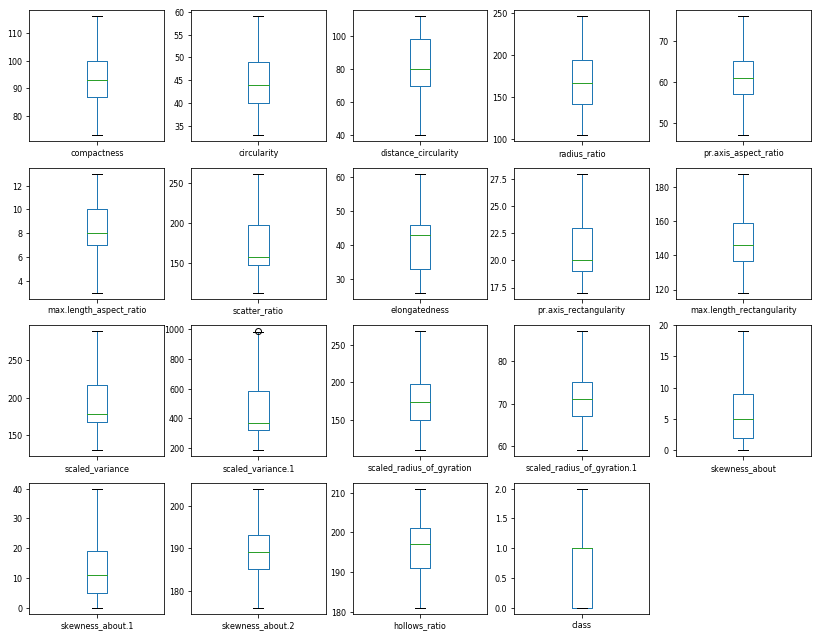

In [58]:
df_vehicles_out.plot(kind='box', subplots=True, layout=(5,5), fontsize=8, figsize=(14,14))
plt.show()

In [59]:
df_vehicles_out.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95    48.000000                  83.0         178.0   
1           91    41.000000                  84.0         141.0   
2          104    50.000000                 106.0         209.0   
3           93    41.000000                  82.0         159.0   
5          107    44.828775                 106.0         172.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
5                  50.0                        6          255.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
5           26.0                    28.0                        169   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
5            280.0              957.0                      264.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
5                         85.0             5.0               9.0   

   skewness_about.2  hollows_ratio  class  
0             187.0            197      2  
1             189.0            199      2  
2             188.0            196      1  
3             199.0            207      2  
5             181.0            183      0

There are multiple ways to detect and remove the outliers but the methods, we have used for this exercise, are widely used and easy to understand. But as per our dataset we can go with IQR Score

# 2. Understanding the attributes - Find relationship between different attributes (Independent variables) and choose carefully which all attributes have to be a part of the analysis and why (5 points)

# Analysing target column distribution

In [60]:
##Let's display how many are car,bus,van. 
df_vehicles_out['class'].value_counts()

1    416
0    208
2    189
Name: class, dtype: int64

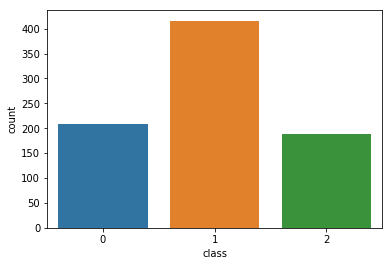

In [61]:
sns.countplot(df_vehicles_out["class"])

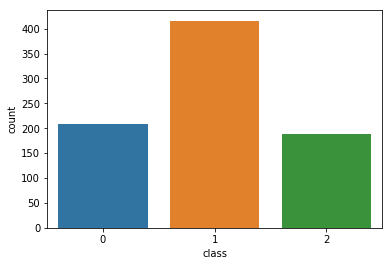

In [62]:
sns.countplot(df_vehicles_out['class'])

# Observation on target variable distirbution

0 -> bus, 1-> car, 2 -> van Target variable don't have balance classification car has higher representation in data set.. so we should be careful as modeling might get baised toward car repersentation

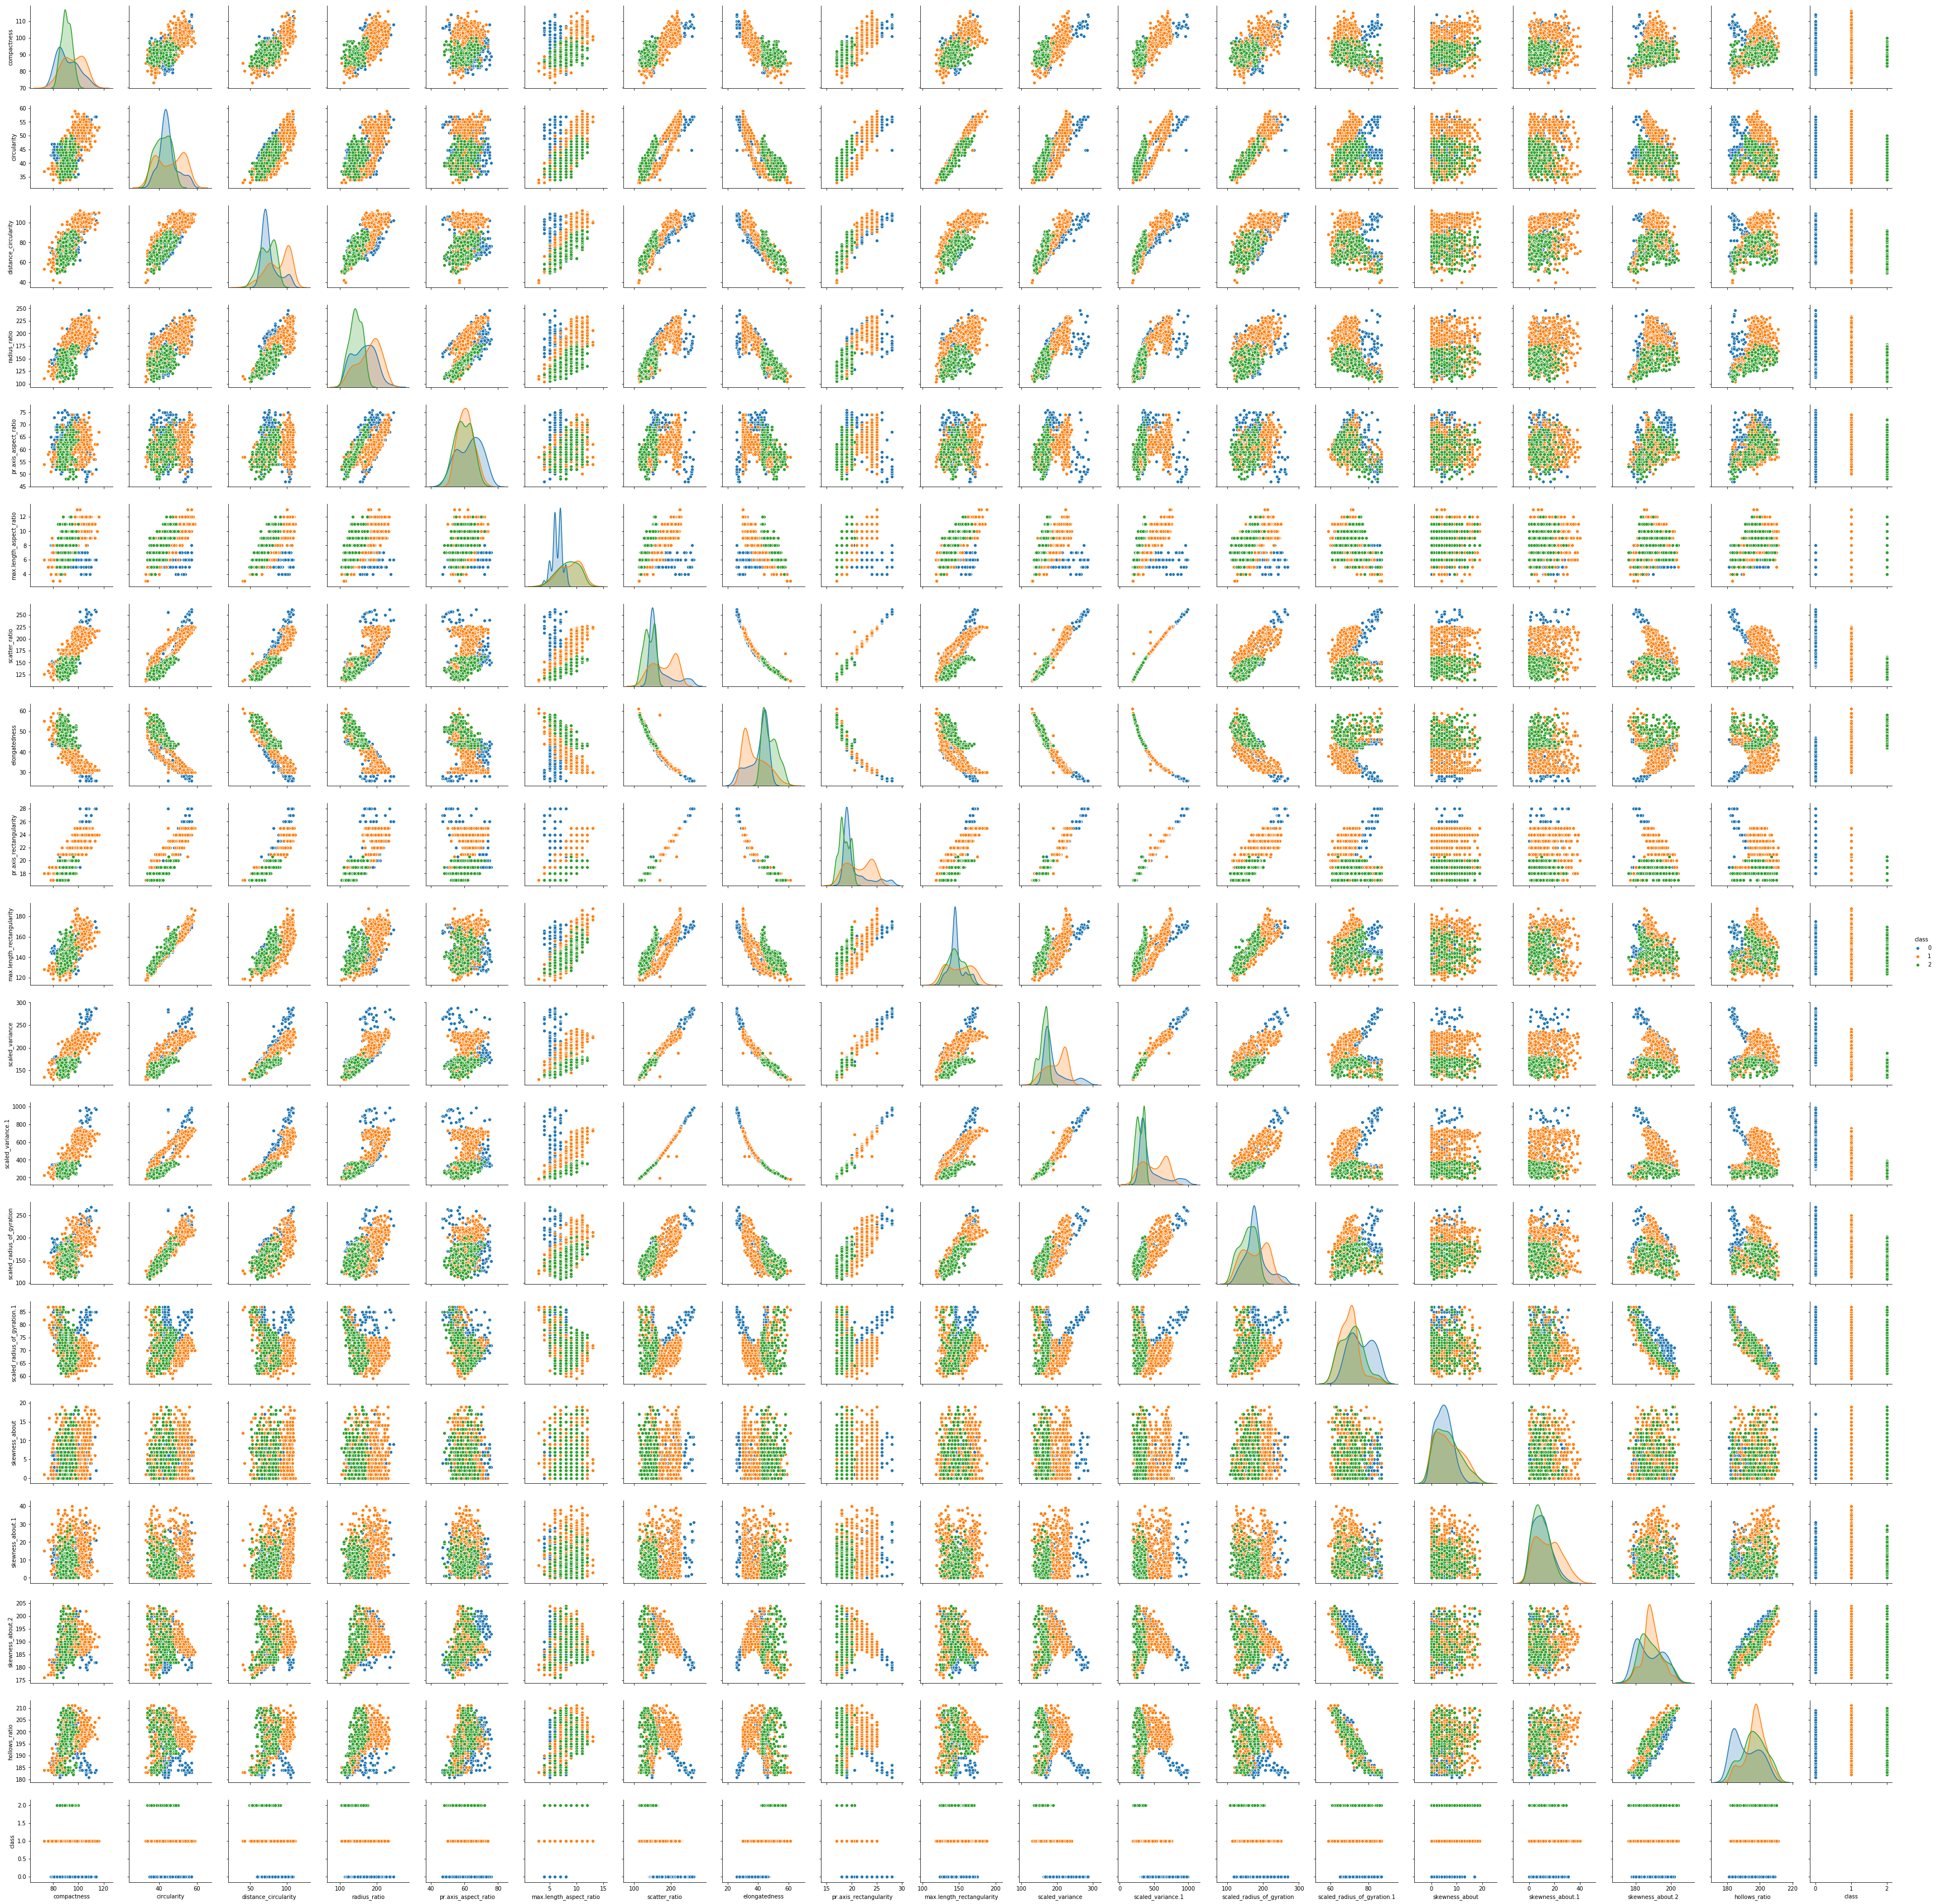

In [63]:
# bivariable analysis
sns.pairplot(df_vehicles_out,diag_kind="kde", hue="class")

Observations for bivariant analysis
The distributions are more separable on some dimensions such as:

max.length_aspect_ratio
elongatedness
scaled_variance
scatter_ratio
scaled_radius_of_gyration.1
scaled_variance.1
pr.axis_rectangularity
scaled_radius_of_gyration
The distributions are not separable on some dimensions such as:

compactness
distance_circularity
max.length_rectangularity
skewness_about.1
skewness_about.2

In [70]:
# Analysing independent variable correlation with each other and target variable
corr_matrix = df_vehicles_out.corr()
corr_matrix

compactness  circularity  distance_circularity  \
compactness                     1.000000     0.679901              0.786810   
circularity                     0.679901     1.000000              0.787513   
distance_circularity            0.786810     0.787513              1.000000   
radius_ratio                    0.746091     0.641013              0.808392   
pr.axis_aspect_ratio            0.200887     0.205616              0.245423   
max.length_aspect_ratio         0.497660     0.563732              0.668662   
scatter_ratio                   0.810430     0.844049              0.904856   
elongatedness                  -0.788449    -0.816212             -0.908822   
pr.axis_rectangularity          0.811810     0.841827              0.894892   
max.length_rectangularity       0.674166     0.961873              0.768843   
scaled_variance                 0.792230     0.803324              0.884633   
scaled_variance.1               0.814537     0.835218              0.889593   
scaled_radius_of_gyration       0.577596     0.926273              0.702683   
scaled_radius_of_gyration.1    -0.254274     0.067633             -0.237766   
skewness_about                  0.200199     0.140639              0.098711   
skewness_about.1                0.161505    -0.014774              0.263514   
skewness_about.2                0.295404    -0.118122              0.128336   
hollows_ratio                   0.364160     0.038081              0.320969   
class                          -0.028066    -0.151426             -0.058983   

                             radius_ratio  pr.axis_aspect_ratio  \
compactness                      0.746091              0.200887   
circularity                      0.641013              0.205616   
distance_circularity             0.808392              0.245423   
radius_ratio                     1.000000              0.666403   
pr.axis_aspect_ratio             0.666403              1.000000   
max.length_aspect_ratio          0.460737              0.138243   
scatter_ratio                    0.789305              0.199988   
elongatedness                   -0.844374             -0.302280   
pr.axis_rectangularity           0.763736              0.169522   
max.length_rectangularity        0.577067              0.146175   
scaled_variance                  0.793528              0.215642   
scaled_variance.1                0.778087              0.187041   
scaled_radius_of_gyration        0.550726              0.153722   
scaled_radius_of_gyration.1     -0.403672             -0.325331   
skewness_about                   0.040348             -0.051643   
skewness_about.1                 0.187295             -0.028793   
skewness_about.2                 0.418257              0.406247   
hollows_ratio                    0.504630              0.419789   
class                           -0.225840             -0.216783   

                             max.length_aspect_ratio  scatter_ratio  \
compactness                                 0.497660       0.810430   
circularity                                 0.563732       0.844049   
distance_circularity                        0.668662       0.904856   
radius_ratio                                0.460737       0.789305   
pr.axis_aspect_ratio                        0.138243       0.199988   
max.length_aspect_ratio                     1.000000       0.497043   
scatter_ratio                               0.497043       1.000000   
elongatedness                              -0.502220      -0.971404   
pr.axis_rectangularity                      0.497641       0.989034   
max.length_rectangularity                   0.647844       0.806303   
scaled_variance                             0.411749       0.977143   
scaled_variance.1                           0.459248       0.993807   
scaled_radius_of_gyration                   0.404216       0.794274   
scaled_radius_of_gyration.1                -0.333074       0.001917   
skewness_about                            

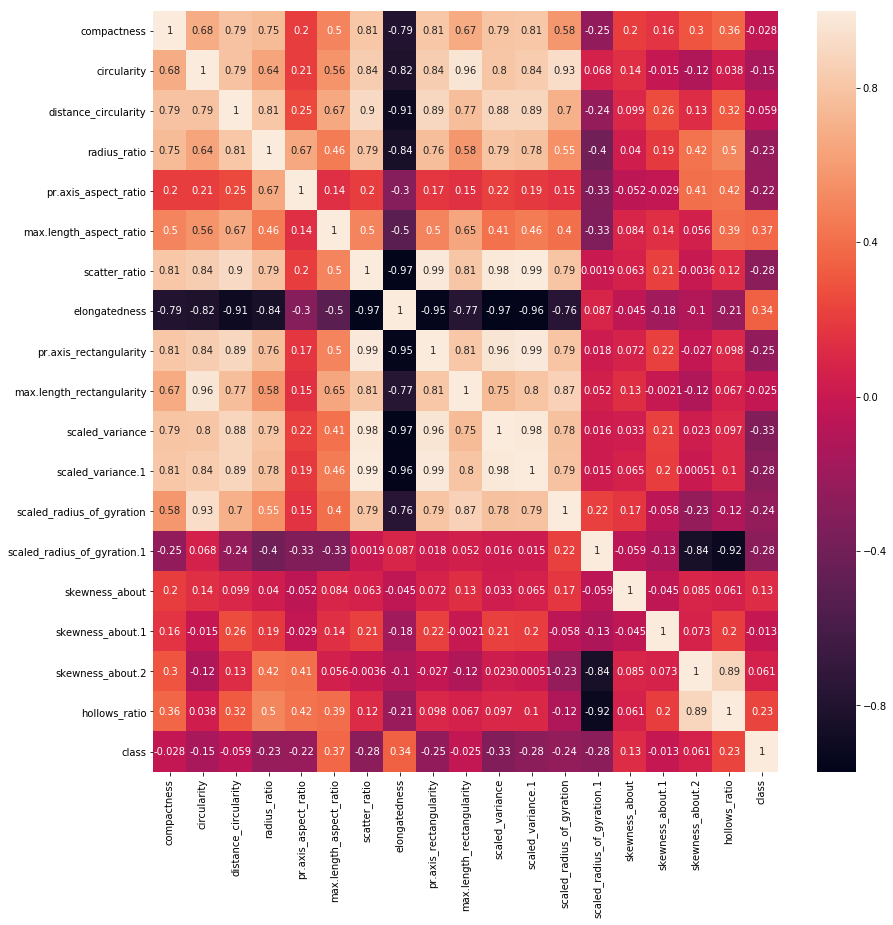

In [69]:
plt.subplots(figsize = (14,14))
sns.heatmap(corr_matrix, annot=True)

# Analysis on corelation of independent variable with each other From the above plot, we can see that:

strong positive correlation between circularity & max_length_rectagularity variables

scatter_ratio have strong positive correlation with pr.axis_rectangularity, scaled_variance, scaled_variance.1

elongatedness variable has strong negative coleration with scatter_ratio, pr.axis_rectangularity, scaled_variance, scaled_variance.1


Multicollinearity happens when one or more of the independent variables are strongly correlated with each other. In such scenarios, we should use only one among correlated independent variables.

# 3. Use PCA from scikit learn and elbow plot to find out a reduced number of dimension (which covers more than 95% of the variance) - 10 points

Passing the X and y value from the Outlier treated DataFame df_vehicles_out

In [71]:
# Split the Vechicle data into separate training (70%) and test (30%) sets and then standardize it to unit variance:
X = df_vehicles_out[df_vehicles_out.columns[0:-1]] # this -1 means the knocking out the last column i.e. target column

In [72]:
X.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95    48.000000                  83.0         178.0   
1           91    41.000000                  84.0         141.0   
2          104    50.000000                 106.0         209.0   
3           93    41.000000                  82.0         159.0   
5          107    44.828775                 106.0         172.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
5                  50.0                        6          255.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
5           26.0                    28.0                        169   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
5            280.0              957.0                      264.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
5                         85.0             5.0               9.0   

   skewness_about.2  hollows_ratio  
0             187.0            197  
1             189.0            199  
2             188.0            196  
3             199.0            207  
5             181.0            183

In [73]:
y = df_vehicles_out[["class"]]

In [74]:
y.head()

class
0      2
1      2
2      1
3      2
5      0

In [75]:
#Splitting the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [76]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(569, 18)
(569, 1)
(244, 18)
(244, 1)


In [77]:
#Normalizing the data using the standard scalar method
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

C:\Users\Nachiappan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Nachiappan\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Nachiappan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Nachiappan\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [79]:
X_train_std

array([[-1.07090974,  0.0504027 , -0.74784732, ..., -0.9729675 ,
        -1.3202284 , -1.61348289],
       [ 0.78761296,  0.5341499 ,  0.82648749, ..., -0.18475457,
         0.4911384 , -0.24892914],
       [-0.32750066, -0.43334451,  0.13378018, ..., -0.07215272,
         1.14981723,  0.70625849],
       ...,
       [-0.32750066, -0.91709172,  0.07080678, ..., -0.29735642,
        -0.16754044, -0.24892914],
       [-1.07090974, -1.72333706, -1.81839499, ...,  0.82866205,
        -0.66154956, -0.93120601],
       [-1.5665158 ,  0.0504027 , -0.8737941 , ..., -1.42337488,
        -0.99088898, -0.93120601]])

In [80]:
X_test_std

array([[-0.56645269,  0.32812494, -0.12561447, ...,  0.27053321,
        -0.30845509, -0.32836348],
       [-0.81593727, -0.52360362, -0.87613436, ..., -0.39623551,
        -0.63147244, -1.00735236],
       [ 2.42736226,  1.3501992 ,  0.69313451, ...,  1.3818144 ,
        -0.14694642,  0.48642318],
       ...,
       [ 1.67890852,  1.69089062,  1.37542532, ..., -0.61849174,
        -0.30845509,  0.21482763],
       [-1.56439101, -0.01256649, -1.01259252, ...,  0.04827697,
        -1.60052448, -1.68634124],
       [ 0.30674334,  1.69089062,  1.37542532, ..., -1.17413234,
        -0.46996376, -0.1925657 ]])

Create a covariance matrix for identifying Principal components

In [81]:
#generating the covariance matrix and the eigenvalues for the PCA analysis
cov_matrix = np.cov(X_train_std.T)
print('Covariance Matrix \n%s', cov_matrix)

Covariance Matrix 
%s [[ 1.00176056e+00  6.94356120e-01  7.87662759e-01  7.50034633e-01
   2.08791726e-01  5.04447667e-01  8.17495899e-01 -7.91734690e-01
   8.18053786e-01  6.91943893e-01  7.99796045e-01  8.21765550e-01
   5.96202943e-01 -2.37027341e-01  1.55871438e-01  1.71139969e-01
   2.80345587e-01  3.49044493e-01]
 [ 6.94356120e-01  1.00176056e+00  8.04532759e-01  6.73037422e-01
   2.41453754e-01  5.90310279e-01  8.52287644e-01 -8.28179117e-01
   8.50386671e-01  9.60883213e-01  8.14224942e-01  8.41918078e-01
   9.25237231e-01  4.23193051e-02  1.21638006e-01  4.00257124e-02
  -1.03407468e-01  6.52469023e-02]
 [ 7.87662759e-01  8.04532759e-01  1.00176056e+00  8.21963950e-01
   2.80504501e-01  6.92241801e-01  9.08359983e-01 -9.14003333e-01
   8.99154021e-01  7.86639803e-01  8.87173270e-01  8.93035502e-01
   7.14689539e-01 -2.47901779e-01  6.30135041e-02  2.88688742e-01
   1.30716827e-01  3.35100980e-01]
 [ 7.50034633e-01  6.73037422e-01  8.21963950e-01  1.00176056e+00
   6.77845347e-

Identify eigen values and eigen vector

In [82]:
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eig_vecs)
print('\n Eigen Values \n%s', eig_vals)

Eigen Vectors 
%s [[-2.70366344e-01 -7.44361634e-02  5.65366101e-02  1.03831896e-01
  -1.65093241e-01  2.86482128e-01  1.82622822e-01 -7.68587962e-01
   3.27191987e-01  1.74680085e-01  1.39203975e-02 -2.18921436e-02
  -8.83517623e-02  1.61945499e-01  2.47992110e-02 -3.13511847e-02
   1.02036856e-02  1.53130914e-03]
 [-2.85516217e-01  1.26198658e-01  1.80335649e-01 -5.86262982e-02
   1.65839412e-01 -7.24201206e-02 -3.90810173e-01 -6.66922241e-02
   9.69115848e-02 -2.58474727e-01  6.13119622e-02  2.06019772e-01
  -3.96101222e-01 -2.71073035e-01  3.94903384e-01 -4.04882075e-01
  -5.83170316e-03 -6.30497724e-02]
 [-3.00368210e-01 -4.32757664e-02 -4.07980506e-02  1.22062762e-01
   7.49447010e-02 -2.47057750e-02  1.85473416e-01  2.72358436e-01
   2.79343331e-01  5.47638294e-02  7.26788903e-01 -3.64477303e-01
   2.70229679e-02 -1.02384583e-01  1.21156819e-01  8.86602565e-02
  -2.22562863e-02  1.37974431e-02]
 [-2.75005564e-01 -1.90978982e-01 -8.97976615e-02 -2.35414840e-01
  -1.34764205e-01 -

In [83]:
print("Eigen Values:")
pd.DataFrame(eig_vals).transpose()

Eigen Values:


0         1        2         3         4         5         6   \
0  9.937412  3.285977  1.20552  1.128455  0.860818  0.672256  0.309964   

         7         8         9         10       11        12        13  \
0  0.231032  0.116106  0.075175  0.058839  0.04596  0.030265  0.025088   

         14       15        16        17  
0  0.019537  0.01662  0.004235  0.008431

In [84]:
tot = sum(eig_vals)

In [85]:
tot

18.031690140845072

In [92]:
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]

In [93]:
var_exp

[55.110815659258414,
 18.22334428009781,
 6.685561786342219,
 6.258176871904595,
 4.7739197455680005,
 3.7281926976506097,
 1.7189979412110055,
 1.2812539052990897,
 0.6438973138145951,
 0.416906956091096,
 0.3263068814076543,
 0.25488552153215377,
 0.16784428582857464,
 0.13913041597074524,
 0.10835041652568853,
 0.09217352458988656,
 0.04675511791253527,
 0.023486678995290958]

In [91]:
var_exp_1 = [( 9.937412 /18.031690140845072 ) * 100 ]  #Examples splitted up the above condition
var_exp_1

[55.11081835578988]

In [95]:
55.110815659258414+18.22334428009781

73.33415993935623

In [94]:
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)
print("Variance Explained", var_exp)

Cumulative Variance Explained [ 55.11081566  73.33415994  80.01972173  86.2778986   91.05181834
  94.78001104  96.49900898  97.78026289  98.4241602   98.84106716
  99.16737404  99.42225956  99.59010385  99.72923426  99.83758468
  99.9297582   99.97651332 100.        ]
Variance Explained [55.110815659258414, 18.22334428009781, 6.685561786342219, 6.258176871904595, 4.7739197455680005, 3.7281926976506097, 1.7189979412110055, 1.2812539052990897, 0.6438973138145951, 0.416906956091096, 0.3263068814076543, 0.25488552153215377, 0.16784428582857464, 0.13913041597074524, 0.10835041652568853, 0.09217352458988656, 0.04675511791253527, 0.023486678995290958]


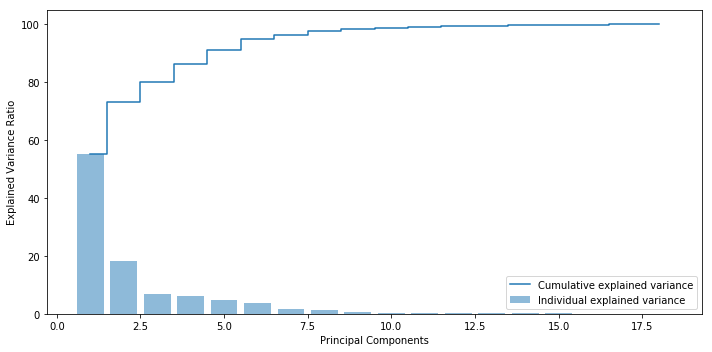

In [96]:
# Ploting 
plt.figure(figsize=(10 , 5))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

Use PCA command from sklearn and find Principal Components. Transform data to components formed We will reduce from 18 dimansion to 8 dimension which covers more than 95% of the variance

In [97]:
# P_reduce represents reduced mathematical space....
P_reduce_1 = np.array(eig_vecs[0:8])   # Reducing from 18 to 8 dimension space
X_train_std_pca = np.dot(X_train_std,P_reduce_1.T)   # projecting original data into principal component dimensions
X_test_std_pca = np.dot(X_test_std,P_reduce_1.T) 
#Proj_data_df_new = pd.DataFrame(X_std_8D_1)
print(X_train_std_pca)
print(X_test_std_pca)
Projected_df_train = pd.DataFrame(X_train_std_pca)
Projected_df_test = pd.DataFrame(X_test_std_pca)

[[-0.33697277  0.22461072 -0.43679755 ... -1.32425416  1.13604438
  -0.88499431]
 [ 0.92432507 -0.02433254  0.42479031 ...  1.74923842 -1.26722202
   0.65043336]
 [-0.35383121  0.62404966  0.24822496 ...  2.17519726 -0.91133541
   0.27934018]
 ...
 [ 0.43708985  0.1043999   0.0507845  ... -0.34275691 -0.1535106
  -0.03017279]
 [-2.37909611  0.01519795 -0.21406136 ... -1.01127882  1.4531644
  -1.12916483]
 [-0.77135526  1.15255412  0.25869985 ...  1.49316625  0.83831895
  -0.02756274]]
[[-0.06562709 -0.02384678  0.12986272 ... -0.50411593  0.52646678
   0.03521005]
 [-0.67329033  0.35293928 -0.21506416 ... -0.95505565  0.61930314
  -1.01653161]
 [ 1.56201262 -1.68390588  0.04133787 ...  0.41241543 -0.77988814
   0.75244148]
 ...
 [ 1.9709851  -0.23941644  0.42571505 ...  1.8366738  -0.77902327
   1.50322878]
 [-0.4581053  -0.39899525 -0.27019944 ... -0.59446865  1.31367089
  -1.0928751 ]
 [ 1.48735397 -0.39423271  0.64285316 ...  1.64670288 -0.44140149
   1.23235192]]


In [98]:
Projected_df_train.head()

0         1         2         3         4         5         6  \
0 -0.336973  0.224611 -0.436798 -0.789550  2.072180 -1.324254  1.136044   
1  0.924325 -0.024333  0.424790 -0.764640 -0.418030  1.749238 -1.267222   
2 -0.353831  0.624050  0.248225  0.274831 -0.401675  2.175197 -0.911335   
3 -0.737420  1.369284 -0.074334 -0.529417 -0.299991  0.257994  0.524544   
4  1.208645 -0.741624  0.585202 -0.539490 -2.114472  1.829424 -0.911417   

          7  
0 -0.884994  
1  0.650433  
2  0.279340  
3  0.128278  
4  0.987790

In [99]:
print(Projected_df_train.shape)
print(Projected_df_test.shape)

(569, 8)
(244, 8)


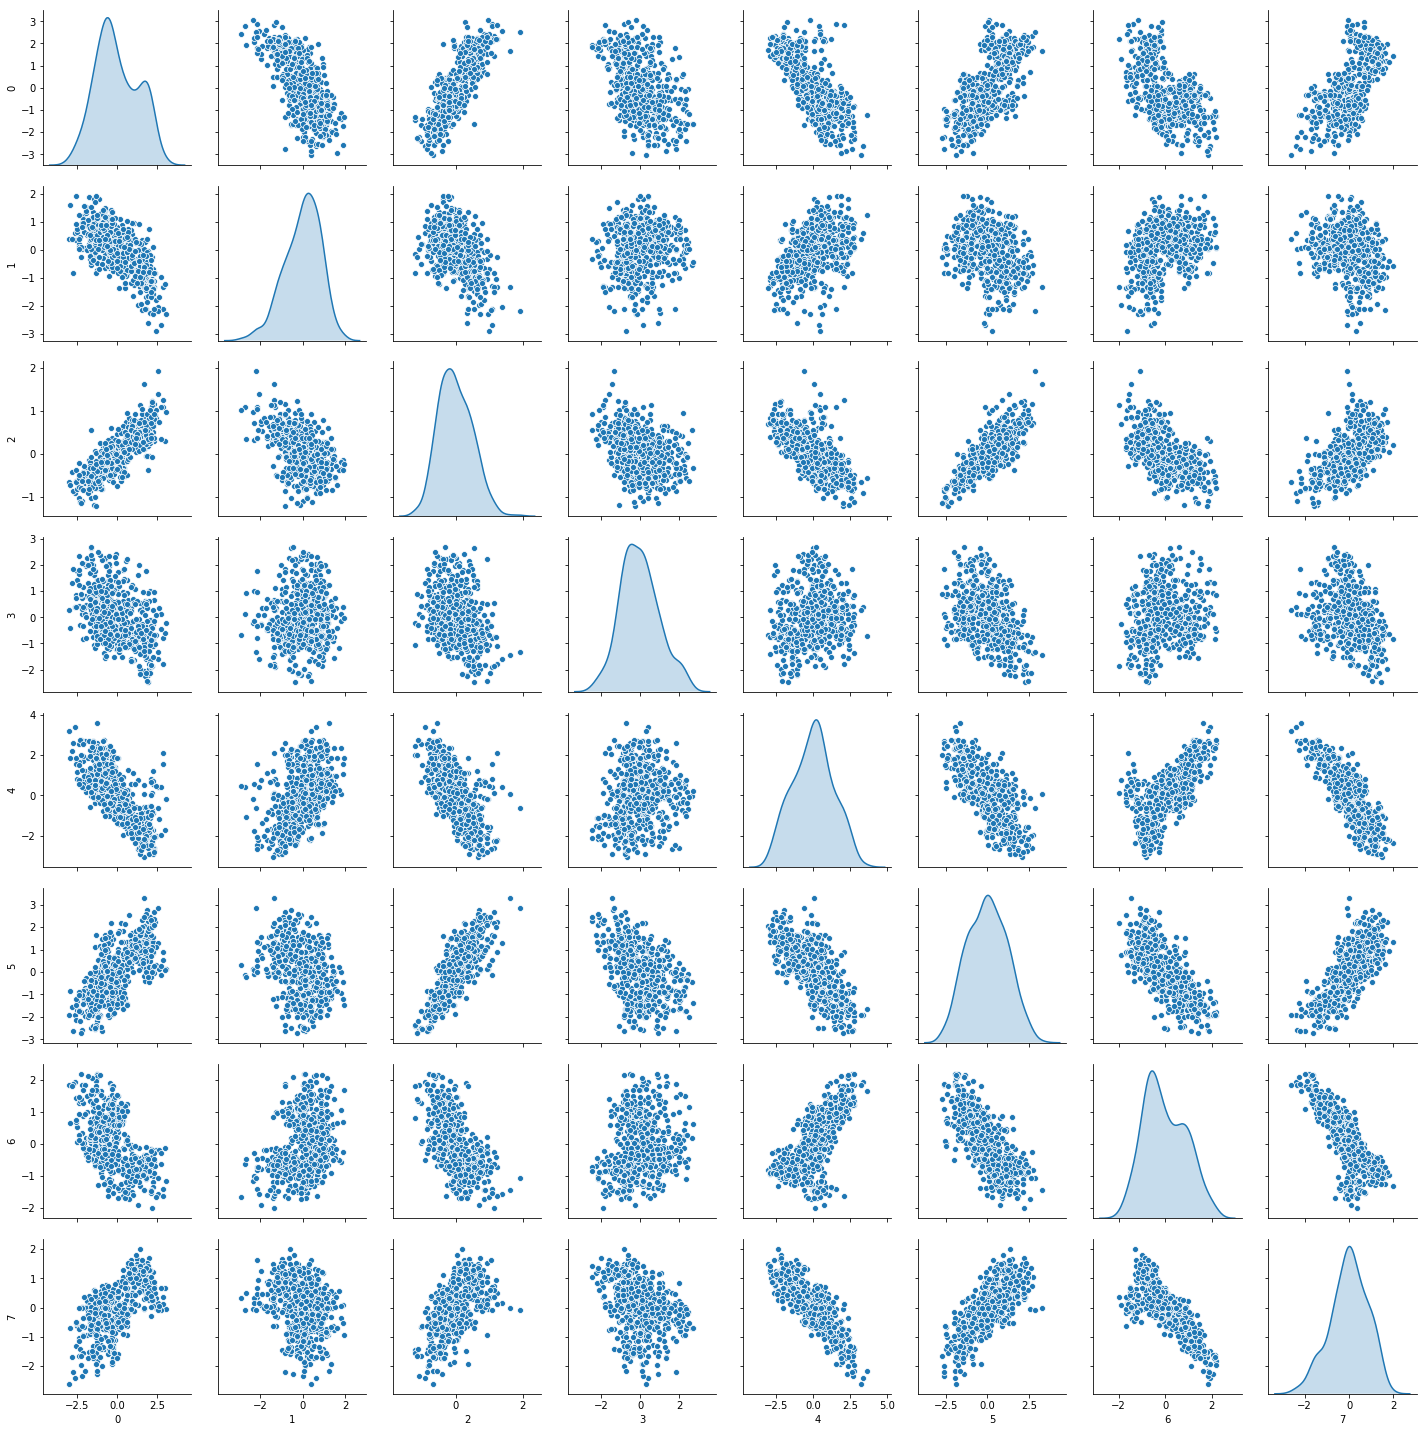

In [100]:
#Let us check it visually
sns.pairplot(Projected_df_train, diag_kind='kde')

As seen above the data seems to be in a cirucal fashion compared to the plot observed in the begining. So PCA has helped in projecting the data.

# 4. Use Support vector machines and use grid search (try C values - 0.01, 0.05, 0.5, 1 and kernel = linear, rbf) and find out the best hyperparameters and do cross-validation to find the accuracy.(10 points)

In [102]:
print(X_train_std_pca.shape)
print(X_test_std_pca.shape)

(569, 8)
(244, 8)


In [118]:
#making the instance
model=SVC(random_state=10)
#Hyper Parameters Set
params = {'C': [0.01, 0.05, 0.5, 1], 
          'kernel': ['linear','rbf']}
#Making models with hyper parameters sets
model1 = GridSearchCV(model, param_grid=params, cv=10, scoring='accuracy')
#Learning
model1.fit(X_train_std_pca,y_train)
#The best hyper parameters set
print("Best Hyper Parameters:\n",model1.best_params_)
#Prediction
prediction=model1.predict(X_test_std_pca)
#importing the metrics module
from sklearn import metrics
#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(prediction,y_test))
#evaluation(Confusion Metrix)
print("Confusion Matrix:\n",metrics.confusion_matrix(prediction,y_test))

Best Hyper Parameters:
 {'C': 1, 'kernel': 'rbf'}
Accuracy: 0.9180327868852459
Confusion Matrix:
 [[ 68   3   0]
 [  1 114   3]
 [  9   4  42]]


In [119]:
#making the instance
model=SVC(random_state=10)
#Hyper Parameters Set
params = {'C': [0.01, 0.05, 0.5, 1], 
          'kernel': ['linear','rbf']}
#Making models with hyper parameters sets
model1 = GridSearchCV(model, param_grid=params, cv=10, scoring='accuracy', n_jobs = -1)
#Learning
model1.fit(X_train_std_pca,y_train)
#The best hyper parameters set
print("Best Hyper Parameters:\n",model1.best_params_)
#Prediction
prediction=model1.predict(X_test_std_pca)
#importing the metrics module
from sklearn import metrics
#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(prediction,y_test))
#evaluation(Confusion Metrix)
print("Confusion Matrix:\n",metrics.confusion_matrix(prediction,y_test))

Best Hyper Parameters:
 {'C': 1, 'kernel': 'rbf'}
Accuracy: 0.9180327868852459
Confusion Matrix:
 [[ 68   3   0]
 [  1 114   3]
 [  9   4  42]]


In [106]:
print("Detailed classification report:")
print(metrics.classification_report(prediction,y_test))

Detailed classification report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91        71
           1       0.94      0.97      0.95       118
           2       0.93      0.76      0.84        55

   micro avg       0.92      0.92      0.92       244
   macro avg       0.92      0.90      0.90       244
weighted avg       0.92      0.92      0.92       244



Creating final SVM model for best hyper parameters of C=1.0 and kernal='rbf'

In [107]:
svm_model = SVC(C=1.0, kernel="rbf", random_state=10)
svm_model.fit(X_train_std_pca,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=10,
  shrinking=True, tol=0.001, verbose=False)

In [108]:
#Prediction
y_predict = svm_model.predict(X_test_std_pca)

# Evaluation: calculate accuracy score on test data(this is unseen data not used while modeling)
acc = metrics.accuracy_score(y_test, y_predict)
print("\nAccuracy Score on test data: ", acc)


Accuracy Score on test data:  0.9180327868852459


In [117]:
print("Confusion Metric & Classification Report ::")
# we can also perform crosstab analysis using Confusion Matric: first argument is true values, second argument is predicted values
# this produces a 3x3 numpy array (matrix)
cm = metrics.confusion_matrix(y_test, y_predict, [0,1,2] )
print("\nConfusion Matrix::\n",cm)

# also analysing cross-tab using classification report for the model
cr = metrics.classification_report(y_test, y_predict)
print("\nClassification Report::\n",cr)

Confusion Metric & Classification Report ::

Confusion Matrix::
 [[ 68   1   9]
 [  3 114   4]
 [  0   3  42]]

Classification Report::
               precision    recall  f1-score   support

           0       0.96      0.87      0.91        78
           1       0.97      0.94      0.95       121
           2       0.76      0.93      0.84        45

   micro avg       0.92      0.92      0.92       244
   macro avg       0.90      0.92      0.90       244
weighted avg       0.93      0.92      0.92       244



# Performing Cross validation to get range estimate

In [121]:
# KFold cross validation to get range estimate
num_folds = 10
seed = 7

kfold = KFold(n_splits=num_folds, random_state=seed)
model = SVC(C=1.0, kernel="rbf", random_state=10)
results = cross_val_score(model, X_train_std_pca, y_train, cv=kfold)
print(results)

[0.94736842 0.9122807  0.94736842 0.89473684 0.89473684 0.92982456
 0.96491228 0.94736842 0.9122807  0.98214286]


In [129]:
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 93.330% (2.802%)


In [130]:
cross_val_score(model, X_train_std_pca, y_train, cv=kfold)

array([0.94736842, 0.9122807 , 0.94736842, 0.89473684, 0.89473684,
       0.92982456, 0.96491228, 0.94736842, 0.9122807 , 0.98214286])

In [131]:
results1 = cross_val_score(model, X_test_std_pca, y_test, cv=kfold)
results1

array([0.92      , 1.        , 0.84      , 0.88      , 0.91666667,
       0.83333333, 0.95833333, 0.91666667, 0.75      , 0.95833333])

In [132]:
print("Accuracy: %.3f%% (%.3f%%)" % (results1.mean()*100.0, results1.std()*100.0))

Accuracy: 89.733% (6.974%)


# Summary:

EDA has been performed by cleaning up the data by treating the Outlier and imputing the missing values.

As observered that most of the feaures are co-related and leads to Multicolinearaity Problem

To avoid the Multicolinearaity we use PCA for dimensionality reduction to avoid the strong co-related features.

Splitting the train and test data and standizing them using standard scalar this will help us to avoid the data leakage

Creating the covariance matrix.

Identifying eigen values and eigen vector.

Dimension has been reduced to 18 to 8 using PCA.

Model has been buid using SVC and grid search CV to find the hyper parameter and optained the result of 93%